In [178]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
%matplotlib inline

In [179]:
## For torch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [180]:
## For clustering
from numpy import array
from scipy.cluster.vq import kmeans2

In [181]:
# Fitting a beta distrbution 
from scipy.stats import beta

In [221]:
def generate_data_2D(job=0, n_samples=10000,data_vis=0):
    if job == 0: # Gaussian mixtures 
        x1 = np.random.uniform(-1,1,size = n_samples)
        x2 = np.random.uniform(-1,1,size = n_samples)
        pi1 = ((mlab.bivariate_normal(x1, x2, 0.25, 0.25, -0.5, -0.2)+
               mlab.bivariate_normal(x1, x2, 0.25, 0.25, 0.7, 0.5))/2).clip(max=1)        
        p = np.zeros(n_samples)
        h = np.zeros(n_samples)
               
        for i in range(n_samples):
            rnd = np.random.uniform()
            if rnd > pi1[i]:
                p[i] = np.random.uniform()
                h[i] = 0
            else:
                p[i] = np.random.beta(a = 0.3, b = 4)
                h[i] = 1
        X = np.concatenate([[x1],[x2]]).T
        
        if data_vis == 1:
            fig = plt.figure()
            ax1 = fig.add_subplot(121)
            x_grid = np.arange(-1, 1, 1/100.0)
            y_grid = np.arange(-1, 1, 1/100.0)
            X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
            pi1_grid = ((mlab.bivariate_normal(X_grid, Y_grid, 0.25, 0.25, -0.5, -0.2)+
               mlab.bivariate_normal(X_grid, Y_grid, 0.25, 0.25, 0.7, 0.5))/2).clip(max=1)  
            ax1.pcolor(X_grid, Y_grid, pi1_grid)
            
            ax2 = fig.add_subplot(122)
            alt=ax2.scatter(x1[h==1][1:50], x2[h==1][1:50],color='r')
            nul=ax2.scatter(x1[h==0][1:50], x2[h==0][1:50],color='b')
            ax2.legend((alt,nul),('50 alternatives', '50 nulls'))
            
        return p, h, X
    if job == 1: # Linear trend
        pass
    if job == 2: # Gaussian mixture + linear trend
        pass
    
def BH(x, alpha = 0.05):
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic]

def Storey_BH(x, alpha = 0.05, lamb=0.4):
    pi0_hat=np.divide(np.sum(x>lamb),x.shape[0] *(1-lamb))
    alpha /= pi0_hat
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic], pi0_hat

def p_value_beta_fit(p, lamb=0.8, bin_num=50, vis=0):
    pi_0=np.divide(np.sum(p>lamb), p.shape[0] * (1-lamb))
    temp_p=np.zeros([0])
    step_size=np.divide(1,np.float(bin_num))
    fil_num=np.int(np.divide(pi_0*p.shape[0],bin_num))+1
    for i in range(bin_num):
        p1=p[p>step_size*(i-1)]
        p1=p1[p1 <= step_size*i]
        choice_num= np.max(p1.shape[0] - fil_num,0)
        if choice_num > 1:
            choice=np.random.choice(p1.shape[0], choice_num)
            temp_p=np.concatenate([temp_p,p1[choice]]).T
    if vis==1:
        plt.figure()
        plt.hist(temp_p, bins=100, normed=True)       
    a, b, loc, scale = beta.fit(temp_p,floc=0,fscale=1)
    return pi_0, a, b
def beta_mixture_pdf(x,pi_0,a,b):
    return beta.pdf(x,a,b)*(1-pi_0)+pi_0

def Storey_BH(x, alpha = 0.05, lamb=0.4):
    pi0_hat=np.divide(np.sum(x>lamb),x.shape[0] *(1-lamb))
    alpha /= pi0_hat
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic], pi0_hat

def Opt_t_cal_discrete(p, h, X, num_case=2,step_size=0.0001,ub=0.05,n_samples=10000,alpha=0.05):
    # Fit the beta mixture parameters
    fit_param=np.zeros([num_case, 3])
    for i in range(num_case):
        fit_param[i,:]=p_value_beta_fit(p[X==i])

    # Calculating the ratios 
    t_opt=np.zeros([num_case])
    max_idx=np.argmin(fit_param[:,0])
    x_grid = np.arange(0, ub, step_size)
    t_ratio=np.zeros([num_case,x_grid.shape[0]])
    for i in range(num_case):
        t_ratio[i,:] = np.divide(beta_mixture_pdf(
            x_grid,fit_param[i,0],fit_param[i,1],fit_param[i,2]), fit_param[i,0])

    # Increase the threshold
    for i in range(len(x_grid)):
        t=np.zeros([num_case])
        # undate the search optimal threshold
        t[max_idx]=x_grid[i]
        c=t_ratio[max_idx,i]
        for j in range(num_case):
            if j != max_idx: 
                for k in range(len(x_grid)):
                    if k == len(x_grid)-1:
                        t[j]=x_grid[k]
                        break
                    if t_ratio[j,k+1]<c:
                        t[j]=x_grid[k]
                        break
        # calculate the FDR
        num_dis=0 
        num_fd =0 
        for i in range(num_case):
            num_dis+=np.sum(p[X==i] < t[i])
            num_fd+=np.sum(X==i)*t[i]*fit_param[i,0]

        if np.divide(num_fd,np.float(np.amax([num_dis,1])))<alpha:
            t_opt=t
        else:
            break
    return t_opt

def result_summary(h,pred):
    print("Num of alternatives:",np.sum(h))
    print("Num of discovery:",np.sum(pred))
    print("Num of true discovery:",np.sum(pred * h))
    print("Actual FDR:", 1-np.sum(pred * h) / np.sum(pred))
    
def softmax_prob_cal(X,Centorid, intensity=1):
    dist=np.zeros([n_samples,num_clusters])
    dist+=np.sum(X*X,axis=1, keepdims=True)
    dist+=np.sum(centroid.T*centroid.T,axis=0, keepdims=True)
    dist -= 2*X.dot(centroid.T)
    dist=np.exp(dist*intensity)
    dist /= np.sum(dist,axis=1, keepdims=True)
    return dist

Here I copied the result for different initialization methods: 

- BHq constant initialization

('Num of alternatives:', 2274.0)
('Num of discovery:', 992.0)
('Num of true discovery:', 982.0)
('Actual FDR:', 0.010080645161290369)

- Storey BHq constant initialization 

('Num of alternatives:', 2274.0)
('Num of discovery:', 987.0)
('Num of true discovery:', 964.0)
('Actual FDR:', 0.023302938196555267)

- K-cluster initialization

('Num of alternatives:', 2274.0)
('Num of discovery:', 1090.0)
('Num of true discovery:', 1069.0)
('Actual FDR:', 0.019266055045871533)

- Soft K-cluster initialization

('Num of alternatives:', 2274.0)
('Num of discovery:', 1012.0)
('Num of true discovery:', 997.0)
('Actual FDR:', 0.014822134387351804)

('Num of alt: ', 2242.0)
('True null prop: ', 0.77580000000000005)
('BH: num of dis, threshold:', 681, 0.0033953484581445851)
('Storey_BH: num of dis, threshold, null esti', 774, 0.0049578217007530748, 0.78033333333333332)


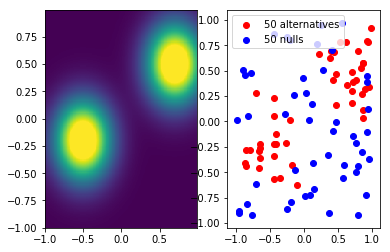

In [222]:
n_samples=10000
p, h, X = generate_data_2D(data_vis=1,n_samples=n_samples)
print("Num of alt: ", np.sum(h))
print("True null prop: ", 1-np.sum(h)/n_samples)
dic_BH, t_BH = BH(p)
print("BH: num of dis, threshold:", dic_BH,t_BH)
dic_SBH, t_SBH, pi0_SBH = Storey_BH(p)
print("Storey_BH: num of dis, threshold, null esti", dic_SBH, t_SBH, pi0_SBH)

In [223]:
## Initialization
# # 1. BHq constant initialization 
# t_init = t_BH * np.ones([n_samples, 1])

# # 2. Storey BHq constant initialization 
# t_init = t_SBH * np.ones([n_samples, 1])


# 3. K-clster initilization, Storey_BH for constant calculation
num_clusters=4
centroid, labels = kmeans2(X,num_clusters)
t_init=np.ones([n_samples,1])
t_opt=Opt_t_cal_discrete(p, h, labels, num_case=num_clusters) 

# # 3.1 Step function
# for i in range(num_clusters):
#     t_init[labels==i]=t_opt[i]

# 3.2 # Soft initialization: weighed average
softmax_pr=softmax_prob_cal(X,centroid,intensity=2)
t_init = softmax_pr.dot(np.reshape(t_opt,[num_clusters,1]))

# # 4. Soft K-clster initilization, Storey_BH for constant calculation
# num_clusters=4
# centroid, labels = kmeans2(X,num_clusters)
# softmax_pr=softmax_prob_cal(X,centroid)

# for i in range(n_samples):
#     labels[i]=np.random.choice(np.arange(num_clusters), p=softmax_pr[i,:])
# t_init=np.ones([n_samples,1])
# t_opt_soft=Opt_t_cal_discrete(p, h, labels, num_case=num_clusters)  
# print(t_opt_soft)

In [203]:
np.arange(num_clusters)

array([0, 1, 2, 3])

In [152]:
pred=(p<t_init.T)*1
result_summary(h,pred)

('Num of alternatives:', 2204.0)
('Num of discovery:', 1093)
('Num of true discovery:', 1048.0)
('Actual FDR:', 0.041171088746569051)


In [224]:
print(t_BH)
print(centroid)
print(t_opt)

0.00339534845814
[[-0.49717347  0.49645602]
 [-0.48035045 -0.49893529]
 [ 0.51307795 -0.4812678 ]
 [ 0.48780854  0.51446202]]
[ 0.001   0.0119  0.      0.022 ]


In [225]:
network = nn.Sequential(
        nn.Linear(2,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,1),
        nn.Sigmoid()
)

soft_compare = nn.Sigmoid()
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)

for item in network.parameters():
    item.data.uniform_(-0.05, 0.05)

l1loss = nn.L1Loss()

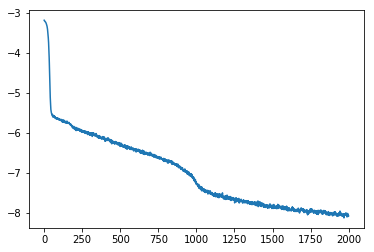

In [226]:
loss_hist = []
batch_size = 2000
pBH = BH(p)[1]
for iteration in range(2000):
    
    choice = np.random.choice(n_samples, batch_size)
    
    x_input = Variable(torch.from_numpy(X[choice,:].astype(np.float32).reshape(batch_size,2)))
    #p_input = Variable(torch.from_numpy(p[choice].astype(np.float32).reshape(batch_size,1)))
#     target = Variable(torch.from_numpy(pBH * np.ones((batch_size, 1))
#                                        .astype(np.float32).reshape(batch_size,1)))
    target = Variable(torch.from_numpy(t_init[choice,:]
                                       .astype(np.float32).reshape(batch_size,1)))
    
    optimizer.zero_grad()
    output = network.forward(x_input) * 0.1
    
    loss = l1loss(output, target)
    
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])
plt.plot(np.log(loss_hist))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
('s', Variable containing:
 0.1266
[torch.FloatTensor of size 1]
)
('s2', Variable containing:
1.00000e-03 *
  1.0299
[torch.FloatTensor of size 1]
)


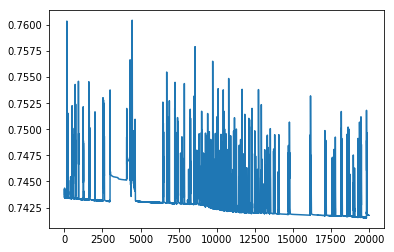

In [235]:

loss_hist = []
batch_size = 10000
n_epoch=20000
for iteration in range(n_epoch):
    if iteration % 500 == 0:
        print iteration
    choice = np.arange(batch_size)
    
    x_input = Variable(torch.from_numpy(X[choice,:].astype(np.float32).reshape(batch_size,2)))
    p_input = Variable(torch.from_numpy(p[choice].astype(np.float32).reshape(batch_size,1)))
    
    
    optimizer.zero_grad()
    output = network.forward(x_input) * 0.1
    s = torch.sum(soft_compare((output - p_input) * 1e3)) / batch_size
    s2 = torch.sum(soft_compare((p_input - (1-output)) * 1e3)) / batch_size
    
    gain = s  - 2 * soft_compare((s2 - s*0.05) * 50) 
    
    loss = -gain
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])

plt.plot(loss_hist)
print('s',s)
print('s2', s2)

('Num of alternatives:', 2242.0)
('Num of discovery:', 1269.0)
('Num of true discovery:', 1248.0)
('Actual FDR:', 0.016548463356974019)
Learned rejection threshold:


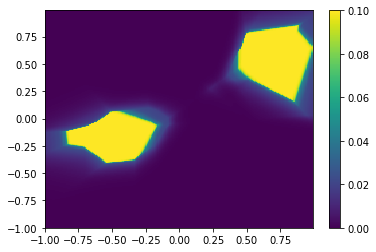

In [236]:
x_input = Variable(torch.from_numpy(X.astype(np.float32).reshape(n_samples ,2)))
p_input = Variable(torch.from_numpy(p.astype(np.float32).reshape(n_samples ,1)))

output = network.forward(x_input) * 0.1
pred = (p_input < output).data.numpy()
pred = pred[:,0].astype(np.float32)

print("Num of alternatives:",np.sum(h))
print("Num of discovery:",np.sum(pred))
print("Num of true discovery:",np.sum(pred * h))
print("Actual FDR:", 1-np.sum(pred * h) / np.sum(pred))

# Visuaizing the rejection threshold
x_grid = np.arange(-1, 1, 1/100.0)
y_grid = np.arange(-1, 1, 1/100.0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

x_in = Variable(torch.from_numpy(
    np.concatenate([[X_grid.flatten()], [Y_grid.flatten()]]).T.astype(np.float32)))
out = network(x_in)
z = out.data.numpy().reshape(X_grid.shape)

print('Learned rejection threshold:')
plt.figure()
plt.pcolor(X_grid, Y_grid, z*0.1)
plt.colorbar()